# PocketMatch Similarities Analysis

## Memory-Efficient Loading of Large CSV Files

We have 108 CSV files totaling ~6GB with 500,000+ rows each. We'll use a memory-efficient approach:

1. **Parquet format**: Much more memory-efficient than CSV (columnar storage, compression)
2. **Chunked conversion**: Convert CSV → Parquet in chunks to avoid memory overflow
3. **PyArrow backend**: Use PyArrow for efficient Parquet I/O
4. **Memory monitoring**: Track memory usage and stop if it gets too high

**Why Parquet?**
- **Compression**: 5-10x smaller than CSV
- **Columnar storage**: Only load columns you need
- **Fast reads**: Much faster than CSV parsing
- **Type preservation**: Maintains data types efficiently

In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path
from tqdm import tqdm
import psutil
import gc
import warnings
import os
warnings.filterwarnings('ignore')

# Memory monitoring
def get_memory_usage_mb():
    """Get current memory usage in MB"""
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024

def get_available_memory_mb():
    """Get available system memory in MB"""
    return psutil.virtual_memory().available / 1024 / 1024

print(f"Initial memory usage: {get_memory_usage_mb():.1f} MB")
print(f"Available memory: {get_available_memory_mb():.1f} MB")

Initial memory usage: 129.6 MB
Available memory: 108812.1 MB


In [2]:
# Configuration
csv_dir = Path('/media/onur/Elements/cavity_space_consensus_docking/2025_06_29_batch_dock/pocketmatch_results/PocketMatch_similarities')
parquet_output_dir = csv_dir.parent / 'parquet_data'
parquet_output_dir.mkdir(exist_ok=True)

# Memory safety thresholds
MAX_MEMORY_USAGE_MB = 8000  # Stop if process uses more than 8GB
MIN_AVAILABLE_MEMORY_MB = 2000  # Stop if less than 2GB available

# Get all CSV files
csv_files = sorted(csv_dir.glob('similarities_part_*.csv'))
print(f"Found {len(csv_files)} CSV files")
print(f"Total size: {sum(f.stat().st_size for f in csv_files) / 1024**3:.2f} GB")

Found 108 CSV files
Total size: 5.92 GB


## Step 1: Convert CSV to Parquet (Memory-Efficient)

Convert each CSV file to Parquet format using chunked reading to minimize memory usage.

In [3]:
def convert_csv_to_parquet_chunked(csv_file, parquet_file, chunk_size=100000):
    """
    Convert CSV to Parquet using chunked reading to minimize memory usage.
    
    Args:
        csv_file: Path to input CSV file
        parquet_file: Path to output Parquet file
        chunk_size: Number of rows to process at a time
    
    Returns:
        True if successful, False if memory limit exceeded
    """
    # Check memory before starting
    if get_memory_usage_mb() > MAX_MEMORY_USAGE_MB:
        print(f"⚠️  Memory limit exceeded before starting: {get_memory_usage_mb():.1f} MB")
        return False
    
    if get_available_memory_mb() < MIN_AVAILABLE_MEMORY_MB:
        print(f"⚠️  Low available memory: {get_available_memory_mb():.1f} MB")
        return False
    
    # Read CSV in chunks and write to Parquet
    parquet_writer = None
    
    try:
        for chunk_idx, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
            # Convert to PyArrow Table for efficient Parquet writing
            table = pa.Table.from_pandas(chunk)
            
            # Write to Parquet file (append mode)
            if parquet_writer is None:
                parquet_writer = pq.ParquetWriter(parquet_file, table.schema, compression='snappy')
            
            parquet_writer.write_table(table)
            
            # Clear memory
            del chunk, table
            gc.collect()
            
            # Check memory after each chunk
            if get_memory_usage_mb() > MAX_MEMORY_USAGE_MB:
                print(f"⚠️  Memory limit exceeded during processing: {get_memory_usage_mb():.1f} MB")
                if parquet_writer:
                    parquet_writer.close()
                return False
        
        if parquet_writer:
            parquet_writer.close()
        
        return True
        
    except Exception as e:
        print(f"Error converting {csv_file.name}: {e}")
        if parquet_writer:
            parquet_writer.close()
        return False

# Convert all CSV files to Parquet
converted_files = []
print("Converting CSV files to Parquet format...")
print(f"Memory safety: Max process usage = {MAX_MEMORY_USAGE_MB} MB, Min available = {MIN_AVAILABLE_MEMORY_MB} MB\n")

for csv_file in tqdm(csv_files, desc="Converting files"):
    parquet_file = parquet_output_dir / csv_file.name.replace('.csv', '.parquet')
    
    # Skip if already converted
    if parquet_file.exists():
        converted_files.append(parquet_file)
        continue
    
    # Convert with memory monitoring
    success = convert_csv_to_parquet_chunked(csv_file, parquet_file, chunk_size=100000)
    
    if not success:
        print(f"\n❌ Stopped conversion due to memory constraints")
        print(f"Converted {len(converted_files)} out of {len(csv_files)} files")
        break
    
    converted_files.append(parquet_file)
    
    # Show memory status every 10 files
    if len(converted_files) % 10 == 0:
        print(f"  Memory: {get_memory_usage_mb():.1f} MB used, {get_available_memory_mb():.1f} MB available")

print(f"\n✅ Converted {len(converted_files)} files to Parquet format")
print(f"Memory usage: {get_memory_usage_mb():.1f} MB")

# Calculate compression ratio
if converted_files:
    csv_size = sum(f.stat().st_size for f in csv_files[:len(converted_files)]) / 1024**3
    parquet_size = sum(f.stat().st_size for f in converted_files) / 1024**3
    print(f"CSV size: {csv_size:.2f} GB")
    print(f"Parquet size: {parquet_size:.2f} GB") 
    print(f"Compression ratio: {csv_size/parquet_size:.1f}x")

Converting CSV files to Parquet format...
Memory safety: Max process usage = 8000 MB, Min available = 2000 MB



Converting files: 100%|██████████| 108/108 [00:00<00:00, 5336.39it/s]


✅ Converted 108 files to Parquet format
Memory usage: 130.3 MB
CSV size: 5.92 GB
Parquet size: 1.09 GB
Compression ratio: 5.4x


## Step 2: Load Parquet Files into Single DataFrame

Now load the Parquet files. This is much more memory-efficient than loading CSVs.

In [4]:
def load_parquet_files_safely(parquet_files, max_files=None):
    """
    Load Parquet files into a single DataFrame with memory monitoring.
    
    Args:
        parquet_files: List of Parquet file paths
        max_files: Maximum number of files to load (None = all)
    
    Returns:
        Combined DataFrame or None if memory limit exceeded
    """
    dfs = []
    files_to_load = parquet_files[:max_files] if max_files else parquet_files
    
    print(f"Loading {len(files_to_load)} Parquet files...")
    print(f"Initial memory: {get_memory_usage_mb():.1f} MB\n")
    
    for i, parquet_file in enumerate(tqdm(files_to_load, desc="Loading files")):
        # Check memory before loading
        current_memory = get_memory_usage_mb()
        available_memory = get_available_memory_mb()
        
        if current_memory > MAX_MEMORY_USAGE_MB:
            print(f"\n⚠️  Memory limit exceeded: {current_memory:.1f} MB")
            print(f"Loaded {i} out of {len(files_to_load)} files")
            break
        
        if available_memory < MIN_AVAILABLE_MEMORY_MB:
            print(f"\n⚠️  Low available memory: {available_memory:.1f} MB")
            print(f"Loaded {i} out of {len(files_to_load)} files")
            break
        
        # Load Parquet file (much faster and more memory-efficient than CSV)
        df = pd.read_parquet(parquet_file)
        dfs.append(df)
        
        # Show progress every 20 files
        if (i + 1) % 20 == 0:
            print(f"  Memory: {current_memory:.1f} MB used, {available_memory:.1f} MB available")
    
    if not dfs:
        print("No files loaded!")
        return None
    
    # Combine all DataFrames
    print(f"\nCombining {len(dfs)} DataFrames...")
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Clear intermediate DataFrames
    del dfs
    gc.collect()
    
    print(f"✅ Loaded {len(combined_df):,} rows")
    print(f"Final memory usage: {get_memory_usage_mb():.1f} MB")
    
    return combined_df

# Load all Parquet files
df_similarities = load_parquet_files_safely(converted_files)

Loading 108 Parquet files...
Initial memory: 130.3 MB



Loading files:   0%|          | 0/108 [00:00<?, ?it/s]

Loading files:  19%|█▉        | 21/108 [00:02<00:10,  8.70it/s]

  Memory: 805.2 MB used, 108271.1 MB available


Loading files:  38%|███▊      | 41/108 [00:04<00:07,  9.51it/s]

  Memory: 1165.3 MB used, 107824.6 MB available


Loading files:  56%|█████▋    | 61/108 [00:06<00:05,  9.13it/s]

  Memory: 1585.0 MB used, 107444.3 MB available


Loading files:  74%|███████▍  | 80/108 [00:08<00:03,  9.16it/s]

  Memory: 2006.2 MB used, 107017.2 MB available


Loading files:  93%|█████████▎| 100/108 [00:11<00:00,  8.91it/s]

  Memory: 2426.2 MB used, 106610.4 MB available


Loading files: 100%|██████████| 108/108 [00:11<00:00,  9.01it/s]



Combining 108 DataFrames...
✅ Loaded 72,107,513 rows
Final memory usage: 4233.9 MB


## Step 3: Inspect the Loaded Data

In [5]:
# Display DataFrame information
if 'df_similarities' in locals():
    print(f"Total rows: {len(df_similarities):,}")
    print(f"Total unique pockets: {len(set(df_similarities['Pocket1'].unique()) | set(df_similarities['Pocket2'].unique())):,}")
    print(f"\nMemory usage: {df_similarities.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"\nDataFrame info:")
    df_similarities.info()
    print(f"\nFirst few rows:")
    display(df_similarities.head(10))
    print(f"\nSummary statistics:")
    display(df_similarities.describe())
else:
    print("DataFrame 'df_similarities' not found. Run the conversion and loading steps first.")

Total rows: 72,107,513
Total unique pockets: 12,145

Memory usage: 13640.46 MB

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72107513 entries, 0 to 72107512
Data columns (total 4 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Pocket1  object 
 1   Pocket2  object 
 2   Pmin     float64
 3   Pmax     float64
dtypes: float64(2), object(2)
memory usage: 2.1+ GB

First few rows:


,Pocket1,Pocket2,Pmin,Pmax
0,AF-Q8WXI7-F67-model_v1_cavity_7.pdb,AF-Q8WXI7-F66-model_v1_cavity_4.pdb,0.939520,0.930688
1,AF-Q9ULT8-F1-model_v1_cavity_3.pdb,AF-Q9Y6K5-F1-model_v1_cavity_1.pdb,0.931197,0.914896
2,AF-Q9ULT8-F1-model_v1_cavity_6.pdb,AF-O60346-F1-model_v1_cavity_6.pdb,0.921233,0.911219
3,AF-Q7Z6Z7-F1-model_v1_cavity_4.pdb,AF-Q63HN8-F8-model_v1_cavity_3.pdb,0.947590,0.909060
4,AF-Q9HAV4-F1-model_v1_cavity_3.pdb,AF-Q9Y6K1-F1-model_v1_cavity_1.pdb,0.916600,0.908961
5,AF-Q9BYT9-F1-model_v1_cavity_11.pdb,AF-O94886-F1-model_v1_cavity_1.pdb,0.913964,0.899418
6,AF-Q6IE37-F1-model_v1_cavity_5.pdb,AF-Q6N022-F4-model_v1_cavity_10.pdb,0.933582,0.898576
7,AF-Q9UBT2-F1-model_v1_cavity_2.pdb,AF-P46721-F1-model_v1_cavity_2.pdb,0.903468,0.898305
8,AF-Q7Z6Z7-F1-model_v1_cavity_4.pdb,AF-Q32P44-F1-model_v1_cavity_3.pdb,0.950642,0.896282
9,AF-Q8IVT5-F1-model_v1_cavity_1.pdb,AF-Q5T4S7-F14-model_v1_cavity_3.pdb,0.896770,0.893640



Summary statistics:


,Pmin,Pmax
count,7.210751e+07,7.210751e+07
mean,8.733710e-01,3.038455e-01
std,1.395441e-01,1.998020e-01
min,5.288000e-03,1.040000e-04
25%,7.994190e-01,1.324260e-01
50%,9.259870e-01,2.746410e-01
75%,9.854570e-01,4.538050e-01
max,1.000000e+00,1.000000e+00


In [6]:
unique_pockets = list(set(df_similarities['Pocket1'].unique()) | set(df_similarities['Pocket2'].unique()))
print(f"Total unique pockets: {len(unique_pockets)}")

Total unique pockets: 12145


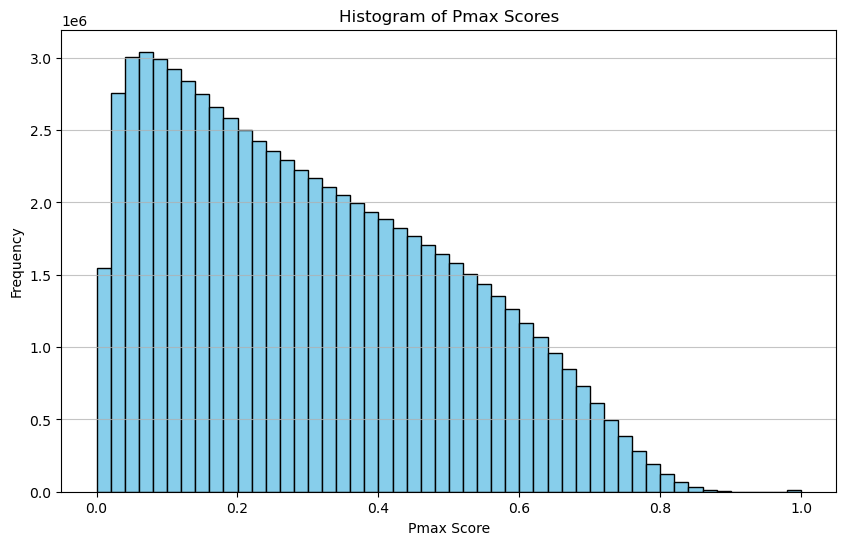

In [7]:
# Plot a histogram of Pmax scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_similarities['Pmax'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Pmax Scores')
plt.xlabel('Pmax Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Step 4: DBSCAN Clustering on Pocket Similarities

We'll cluster pockets using DBSCAN based on their Pmax similarity scores:

- **Similarity threshold**: Pmax >= 0.7 (pockets in same cluster must have high similarity)
- **Distance metric**: Distance = 1 - Pmax (convert similarity to distance)
- **DBSCAN epsilon**: 0.3 (corresponds to Pmax >= 0.7)
- **Minimum cluster size**: 100 pockets per cluster

**Approach**:
1. Take first *N_ROWS* rows of pairwise similarities
2. Build a distance matrix from unique pockets
3. Run DBSCAN with eps=0.3, min_samples=100

In [8]:
from sklearn.cluster import DBSCAN
from scipy.sparse import lil_matrix, csr_matrix
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import numba
from numba import jit, prange

# Remove rows that show identical pockets (i.e. self-comparisons)
df_similarities = df_similarities[df_similarities['Pocket1'] != df_similarities['Pocket2']]

# Take first N_ROWS rows for clustering
N_ROWS = len(df_similarities)  # Use all rows
df_subset = df_similarities.head(N_ROWS).copy()

print(f"Using first {N_ROWS:,} rows for clustering")
print(f"Pmax range: [{df_subset['Pmax'].min():.3f}, {df_subset['Pmax'].max():.3f}]")

# Get unique pockets from the subset
all_pockets = sorted(set(df_subset['Pocket1'].unique()) | set(df_subset['Pocket2'].unique()))
n_pockets = len(all_pockets)
pocket_to_idx = {pocket: idx for idx, pocket in enumerate(all_pockets)}

print(f"Unique pockets in subset: {n_pockets}")

# Build distance matrix using VECTORIZED operations (much faster than iterrows)
print(f"\nBuilding distance matrix (vectorized)...")

# Create distance matrix initialized to 1.0 (no similarity for unknown pairs)
distance_matrix = np.ones((n_pockets, n_pockets), dtype=np.float32)
np.fill_diagonal(distance_matrix, 0)  # Distance to self is 0

# VECTORIZED: Map pocket names to indices using pandas Series.map()
print("  Mapping pockets to indices...")
idx1 = df_subset['Pocket1'].map(pocket_to_idx).values
idx2 = df_subset['Pocket2'].map(pocket_to_idx).values
distances = (1.0 - df_subset['Pmax'].values).astype(np.float32)

print(f"  Filling {len(idx1):,} entries in distance matrix...")

# Use numba for fast parallel filling of the distance matrix
@jit(nopython=True, parallel=True)
def fill_distance_matrix(dist_matrix, idx1, idx2, distances):
    """Fill distance matrix in parallel using numba"""
    n = len(idx1)
    for i in prange(n):
        i1 = idx1[i]
        i2 = idx2[i]
        d = distances[i]
        dist_matrix[i1, i2] = d
        dist_matrix[i2, i1] = d  # Symmetric
    return dist_matrix

# Fill the matrix (first call compiles, subsequent calls are fast)
distance_matrix = fill_distance_matrix(distance_matrix, idx1, idx2, distances)

print(f"✅ Distance matrix built!")
print(f"Distance matrix shape: {distance_matrix.shape}")
print(f"Memory usage: {distance_matrix.nbytes / 1024**2:.2f} MB")

Using first 72,096,576 rows for clustering
Pmax range: [0.000, 1.000]
Unique pockets in subset: 12145

Building distance matrix (vectorized)...
  Mapping pockets to indices...
  Filling 72,096,576 entries in distance matrix...
✅ Distance matrix built!
Distance matrix shape: (12145, 12145)
Memory usage: 562.67 MB


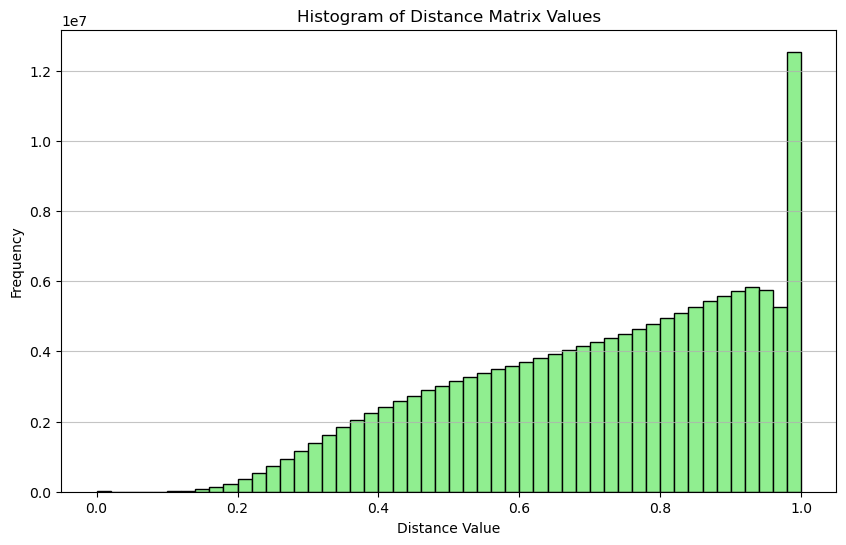

In [9]:
# Plot a histogram of values in the distance matrix
plt.figure(figsize=(10, 6))
plt.hist(distance_matrix.flatten(), bins=50, color='lightgreen', edgecolor='black')
plt.title('Histogram of Distance Matrix Values')
plt.xlabel('Distance Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

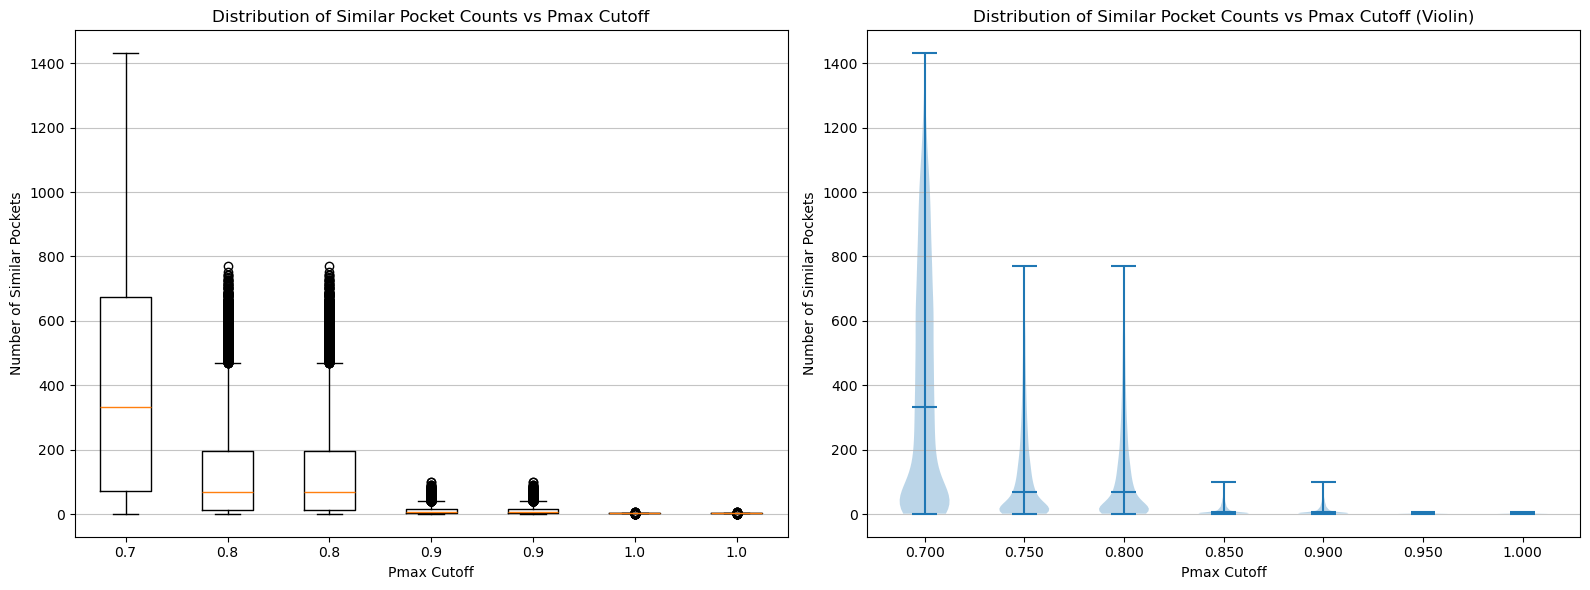


Summary statistics for each Pmax cutoff:
               count        mean         std  min   25%    50%    75%     max
Pmax Cutoff                                                                  
0.7          10871.0  405.170454  350.690613  1.0  72.0  334.0  674.0  1431.0
0.8          17331.0  131.391495  153.467297  1.0  14.0   69.0  196.0   770.0
0.9           5891.0   12.215923   15.474648  1.0   2.0    5.0   17.0   101.0
1.0            115.0    2.121739    0.956491  1.0   2.0    2.0    2.0     5.0


In [10]:
# Plot distributions of the number of highly similar pockets with Pmax > Pmax_cutoff for each Pocket1 or Pocket2

Pmax_cutoffs = np.arange(0.7, 1.0, 0.05)
all_counts_data = []

for cutoff in Pmax_cutoffs:
    threshold = cutoff
    # Count similar pockets for Pocket1
    counts1 = df_similarities[df_similarities['Pmax'] > threshold].groupby('Pocket1').size()
    # Count similar pockets for Pocket2
    counts2 = df_similarities[df_similarities['Pmax'] > threshold].groupby('Pocket2').size()
    # Combine counts
    total_counts = counts1.add(counts2, fill_value=0)
    
    # Store data for plotting
    for count in total_counts.values:
        all_counts_data.append({'Pmax Cutoff': f'{cutoff:.1f}', 'Similar Pockets': count})

# Create DataFrame for plotting
df_plot = pd.DataFrame(all_counts_data)

# Create figure with boxplot and violin plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot
axes[0].boxplot([df_plot[df_plot['Pmax Cutoff'] == f'{c:.1f}']['Similar Pockets'].values 
                  for c in Pmax_cutoffs], 
                 labels=[f'{c:.1f}' for c in Pmax_cutoffs])
axes[0].set_title('Distribution of Similar Pocket Counts vs Pmax Cutoff')
axes[0].set_xlabel('Pmax Cutoff')
axes[0].set_ylabel('Number of Similar Pockets')
axes[0].grid(axis='y', alpha=0.75)

# Violin plot
parts = axes[1].violinplot([df_plot[df_plot['Pmax Cutoff'] == f'{c:.1f}']['Similar Pockets'].values 
                             for c in Pmax_cutoffs],
                            positions=range(len(Pmax_cutoffs)), showmedians=True)
axes[1].set_xticks(range(len(Pmax_cutoffs)))
axes[1].set_xticklabels([f'{c:.3f}' for c in Pmax_cutoffs])
axes[1].set_title('Distribution of Similar Pocket Counts vs Pmax Cutoff (Violin)')
axes[1].set_xlabel('Pmax Cutoff')
axes[1].set_ylabel('Number of Similar Pockets')
axes[1].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

# Print summary statistics for each cutoff
print("\nSummary statistics for each Pmax cutoff:")
print(df_plot.groupby('Pmax Cutoff')['Similar Pockets'].describe())

In [11]:
def cluster_pockets_louvain(df_similarities, Pmax_min=0.3, resolution=1.5):
    """
    Cluster pockets using Louvain community detection on a similarity graph.
    
    Args:
        df_similarities: DataFrame with columns ['Pocket1', 'Pocket2', 'Pmax']
        Pmax_min: Minimum Pmax threshold for including edges (default: 0.3)
        resolution: Louvain resolution parameter (higher = more clusters, default: 1.5)
    
    Returns:
        G: NetworkX graph with cluster attributes on nodes
        df_clusters: DataFrame with columns ['Pocket', 'Cluster', 'ClusterSize']
    """
    import networkx as nx
    from community import community_louvain
    from collections import Counter
    
    # Step 1: Filter by Pmax threshold
    print(f"Step 1: Filtering edges with Pmax >= {Pmax_min}...")
    df_filtered = df_similarities[df_similarities['Pmax'] >= Pmax_min].copy()
    print(f"  Kept {len(df_filtered):,} / {len(df_similarities):,} edges ({100*len(df_filtered)/len(df_similarities):.1f}%)")
    
    # Step 2: Build graph
    print(f"\nStep 2: Building graph...")
    G = nx.from_pandas_edgelist(
        df_filtered,
        source='Pocket1',
        target='Pocket2',
        edge_attr='Pmax',
    )
    # Rename edge attribute to 'weight' for Louvain
    nx.set_edge_attributes(G, nx.get_edge_attributes(G, 'Pmax'), 'weight')
    print(f"  ✅ Graph built: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
    
    # Step 3: Run Louvain community detection
    print(f"\nStep 3: Running Louvain community detection (resolution={resolution})...")
    partition = community_louvain.best_partition(G, weight='weight', resolution=resolution)
    cluster_sizes = Counter(partition.values())
    print(f"  ✅ Found {len(cluster_sizes)} communities")
    print(f"  Largest 5: {cluster_sizes.most_common(5)}")
    
    # Step 4: Add cluster attributes to nodes
    print(f"\nStep 4: Adding cluster attributes to graph nodes...")
    for node in G.nodes():
        G.nodes[node]['cluster'] = partition.get(node, -1)
        G.nodes[node]['cluster_size'] = cluster_sizes.get(partition.get(node, -1), 0)
    print(f"  ✅ Added 'cluster' and 'cluster_size' attributes to all nodes")
    
    # Step 5: Create cluster membership DataFrame
    print(f"\nStep 5: Creating cluster membership DataFrame...")
    df_clusters = pd.DataFrame([
        {'Pocket': pocket, 'Cluster': cluster_id}
        for pocket, cluster_id in partition.items()
    ])
    df_clusters['ClusterSize'] = df_clusters['Cluster'].map(cluster_sizes)
    df_clusters = df_clusters.sort_values(
        ['ClusterSize', 'Cluster', 'Pocket'], 
        ascending=[False, True, True]
    ).reset_index(drop=True)
    print(f"  ✅ Created DataFrame with {len(df_clusters):,} pockets in {df_clusters['Cluster'].nunique()} clusters")
    
    # Summary
    print(f"\n{'='*50}")
    print(f"SUMMARY")
    print(f"{'='*50}")
    print(f"  Pmax threshold: >= {Pmax_min}")
    print(f"  Total pockets: {len(df_clusters):,}")
    print(f"  Total clusters: {df_clusters['Cluster'].nunique()}")
    print(f"  Largest cluster: {cluster_sizes.most_common(1)[0][1]} pockets")
    print(f"  Smallest cluster: {min(cluster_sizes.values())} pockets")
    print(f"  Median cluster size: {np.median(list(cluster_sizes.values())):.0f} pockets")
    
    return G, df_clusters# 

In [ ]:
network_output_dir = csv_dir.parent / 'pocket_clusters'
G_pmax_min_0p3, df_clusters_pmax_min_0p3 = cluster_pockets_louvain(df_similarities, Pmax_min=0.3, resolution=1.5)
# Export to GEXF (Gephi format)

Step 1: Filtering edges with Pmax >= 0.3...


  Kept 33,210,043 / 72,096,576 edges (46.1%)

Step 2: Building graph...
  ✅ Graph built: 12,143 nodes, 31,755,538 edges

Step 3: Running Louvain community detection (resolution=1.5)...
  ✅ Found 17 communities
  Largest 5: [(3, 4197), (11, 3550), (1, 1309), (2, 899), (14, 878)]

Step 4: Adding cluster attributes to graph nodes...
  ✅ Added 'cluster' and 'cluster_size' attributes to all nodes

Step 5: Creating cluster membership DataFrame...
  ✅ Created DataFrame with 12,143 pockets in 17 clusters

SUMMARY
  Pmax threshold: >= 0.3
  Total pockets: 12,143
  Total clusters: 17
  Largest cluster: 4197 pockets
  Smallest cluster: 1 pockets
  Median cluster size: 22 pockets


NameError: name 'nx' is not defined

In [ ]:
import networkx as nx

nx.write_gexf(G_pmax_min_0p3, os.path.join(network_output_dir, 'pocket_network_louvain_0p3.gexf'))
# Save df_clusters to CSV
df_clusters_pmax_min_0p3.to_csv(os.path.join(network_output_dir, 'pocket_louvain_clusters_0p3.csv'), index=False)

G_pmax_min_0p4, df_clusters_pmax_min_0p4 = cluster_pockets_louvain(df_similarities, Pmax_min=0.4, resolution=1.5)
nx.write_gexf(G_pmax_min_0p4, os.path.join(network_output_dir, 'pocket_network_louvain_0p4.gexf'))
df_clusters_pmax_min_0p4.to_csv(os.path.join(network_output_dir, 'pocket_louvain_clusters_0p4.csv'), index=False)

G_pmax_min_0p5, df_clusters_pmax_min_0p5 = cluster_pockets_louvain(df_similarities, Pmax_min=0.5, resolution=1.5)
nx.write_gexf(G_pmax_min_0p5, os.path.join(network_output_dir, 'pocket_network_louvain_0p5.gexf'))
df_clusters_pmax_min_0p5.to_csv(os.path.join(network_output_dir, 'pocket_louvain_clusters_0p5.csv'), index=False)

G_pmax_min_0p6, df_clusters_pmax_min_0p6 = cluster_pockets_louvain(df_similarities, Pmax_min=0.6, resolution=1.5)
nx.write_gexf(G_pmax_min_0p6, os.path.join(network_output_dir, 'pocket_network_louvain_0p6.gexf'))
df_clusters_pmax_min_0p6.to_csv(os.path.join(network_output_dir, 'pocket_louvain_clusters_0p6.csv'), index=False)

G_pmax_min_0p7, df_clusters_pmax_min_0p7 = cluster_pockets_louvain(df_similarities, Pmax_min=0.7, resolution=1.5)
nx.write_gexf(G_pmax_min_0p7, os.path.join(network_output_dir, 'pocket_network_louvain_0p7.gexf'))
df_clusters_pmax_min_0p7.to_csv(os.path.join(network_output_dir, 'pocket_louvain_clusters_0p7.csv'), index=False)

G_pmax_min_0p8, df_clusters_pmax_min_0p8 = cluster_pockets_louvain(df_similarities, Pmax_min=0.8, resolution=1.5)
nx.write_gexf(G_pmax_min_0p8, os.path.join(network_output_dir, 'pocket_network_louvain_0p8.gexf'))
df_clusters_pmax_min_0p8.to_csv(os.path.join(network_output_dir, 'pocket_louvain_clusters_0p8.csv'), index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/media/onur/Elements/cavity_space_consensus_docking/2025_06_29_batch_dock/pocketmatch_results/pocket_clusters/pocket_network_louvain_0p3.gexf'